In [1]:
import numpy as np
import umap
import os
from PIL import Image
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pathlib import Path

In [4]:
all_names = list(Path('minsci').rglob('*.jpg'))
print(len(all_names))

27993


In [5]:
embeddings_list = []

FILE_BATCH_SIZE = 1000
for start in range(0, len(all_names), FILE_BATCH_SIZE):
    file_subset = all_names[start:start+FILE_BATCH_SIZE]
    if len(file_subset) < FILE_BATCH_SIZE:
        file_end = start + len(file_subset)
    else:
        file_end = start + FILE_BATCH_SIZE
    npy_file = f'minsci_embeddings/embeddings_{start}_{file_end}.npy'
    embeddings = np.load(npy_file)
    embeddings_list.append(embeddings)
all_embeddings = np.vstack(embeddings_list)
all_embeddings.shape

(27993, 512)

In [6]:
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(all_embeddings)

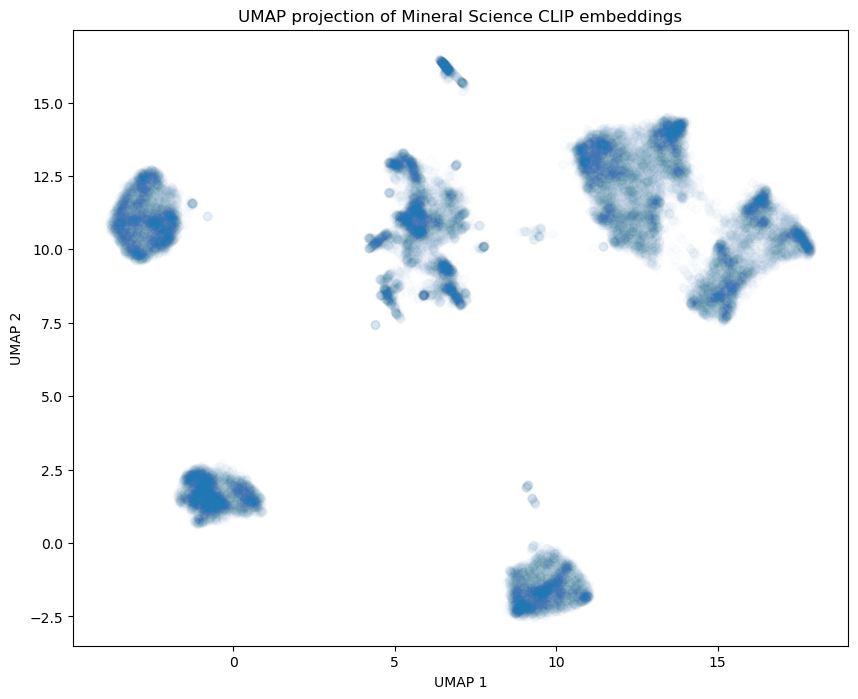

In [7]:
import matplotlib.pyplot as plt

# Assuming 'embedding_umap' contains the UMAP-transformed embeddings

# Plotting the UMAP output
plt.figure(figsize=(10, 8))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], alpha=0.01)
plt.title('UMAP projection of Mineral Science CLIP embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [8]:
import pandas as pd

In [9]:
filename_list = []

FILE_BATCH_SIZE = 1000
for start in range(0, len(all_names), FILE_BATCH_SIZE):
    file_subset = all_names[start:start+FILE_BATCH_SIZE]
    if len(file_subset) < FILE_BATCH_SIZE:
        file_end = start + len(file_subset)
    else:
        file_end = start + FILE_BATCH_SIZE
    tsv_file = f'minsci_probabilities/embeddings_{start}_{file_end}.tsv'
    df = pd.read_csv(tsv_file, sep='\t')
    filenames = df['filename'].tolist()
    filename_list += filenames
len(filename_list)

27993

In [10]:
filename_list[:5]

['m331cfe138-f925-4dc7-818b-de8b2c226f85',
 'm3aa81b85d-4dad-4937-a648-015837dca8a4',
 'm350f7271d-3fa4-438c-9312-0bb12838cef4',
 'm3930c92b9-c3ce-464b-a8f8-c9cddf547b82',
 'm31f820009-4f55-4500-8393-6e36f5ac8093']

In [11]:
embedding_normalized = minmax_scale(embedding_umap)
df = pd.DataFrame(embedding_normalized, index=filename_list, columns = ['x','y'])
df.head()

,x,y
m331cfe138-f925-4dc7-818b-de8b2c226f85,0.688695,0.792031
m3aa81b85d-4dad-4937-a648-015837dca8a4,0.872198,0.584093
m350f7271d-3fa4-438c-9312-0bb12838cef4,0.388819,0.579002
m3930c92b9-c3ce-464b-a8f8-c9cddf547b82,0.086484,0.722946
m31f820009-4f55-4500-8393-6e36f5ac8093,0.497861,0.557616


In [12]:
df = df.sample(5000)
df.head()

,x,y
m3c07a74f7-5203-44de-bc4a-3c04d6938908,0.711497,0.840089
m3f3f1cb8e-2cb7-4d42-b045-6c1877eb3cc6,0.665915,0.843141
m3d3ad4f30-3d4c-45ed-9f29-e8989334852e,0.798355,0.794774
m3ca075d10-a136-4269-87c2-38386402884b,0.957886,0.651231
m3359a8a6e-44dc-40aa-8e0c-32b18a615613,0.412254,0.790524


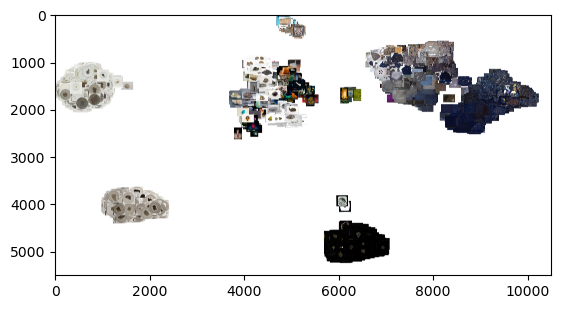

In [14]:
CANVAS_HEIGHT = 5000
CANVAS_WIDTH = 10000
canvas = np.full((CANVAS_HEIGHT+500,CANVAS_WIDTH+500,3),255, dtype=np.uint8)

THUMBNAIL_SIZE = 500,500

for row in df[::-1].itertuples():
    image_path = os.path.join('minsci', row.Index) + '.jpg'
    x_pos = round(row.x * CANVAS_WIDTH)
    y_pos = CANVAS_HEIGHT - round(row.y * CANVAS_HEIGHT)

    pil_image = Image.open(image_path)
    pil_image.thumbnail(THUMBNAIL_SIZE)
    np_image = np.array(pil_image)
    if np_image.ndim == 2:
        # Convert grayscale to RGB by stacking the channels
        np_image = np.stack((np_image,)*3, axis=-1)
    canvas[y_pos:np_image.shape[0]+y_pos,
           x_pos:np_image.shape[1]+x_pos] = np_image    
plt.imshow(canvas)

In [15]:
iz_umap = Image.fromarray(canvas)
iz_umap.save('minsci_umap.png')